In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from scipy.interpolate import interp1d

from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

import glob
from tqdm.notebook import tqdm


import scienceplots
plt.style.use(['ieee','bright','no-latex'])
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.titleweight"]=25

np.random.seed(18)

In [2]:
def find_num(P,threshold):
    n=threshold*P[0]
    for i,val in enumerate(P):
        if val<n:
            return i
    return i+1

def find_missing_blocks(input_list):
    missing_blocks_len = []
    current_block = []

    for item in input_list:
        if pd.isnull(item):  # You can change this condition to match the type of missing value in your list
            current_block.append(item)
        elif current_block:
            missing_blocks_len.append(len(current_block))
            current_block = []

    if current_block:
        missing_blocks_len.append(len(current_block))
    missing_blocks_len.sort(reverse=True)

    if len(missing_blocks_len)==0:
        missing_blocks_len=[0]
    return missing_blocks_len


def score(P,l,t):
    """
    P: Array containing contiguous NaN's in descending order
    l : Length of array
    """
    n=find_num(P,t)
    e1= (1-sum(P)/l)
    #e2= np.exp((1-np.mean(P[:n])/l)**3)/np.exp(1)
    if n==0:
        e2=1
        #warnings.simplefilter("default")
        #warnings.warn("Looks like Threshold>1, So Score returned is just nan %")  
    else:
        e2= (1-np.mean(P[:n])/l)
    return round(e1*e2,4)

def find_score(data,threshold):
    arr_missing=find_missing_blocks(data)
    return score(arr_missing,len(data),threshold)

In [3]:
def calculate_duplicate_percentage(data, consecutive_count=3,count_nan_repeat=False):
    """
    Function to calculate duplicates i.e. check uniqueness of data and see if it is sampled every 15 min.
    """

    if consecutive_count < 2:
        raise ValueError("consecutive_count must be at least 2")
    
    consecutive_duplicates = 0
    total_triplets = 0
    
    for i in range(len(data) - consecutive_count + 1):
        triplet = data[i:i+consecutive_count]
        
        # Check if all values in the triplet are NaN
        if all(np.isnan(val) for val in triplet) and count_nan_repeat:
            consecutive_duplicates += 1
        elif not any(np.isnan(val) for val in triplet):
            # Check if all values in the consecutive set are the same
            if all(triplet[0] == val for val in triplet[1:]):
                consecutive_duplicates += 1
        total_triplets += 1
    
    if total_triplets == 0:
        return 0
    
    return (consecutive_duplicates / total_triplets) * 100

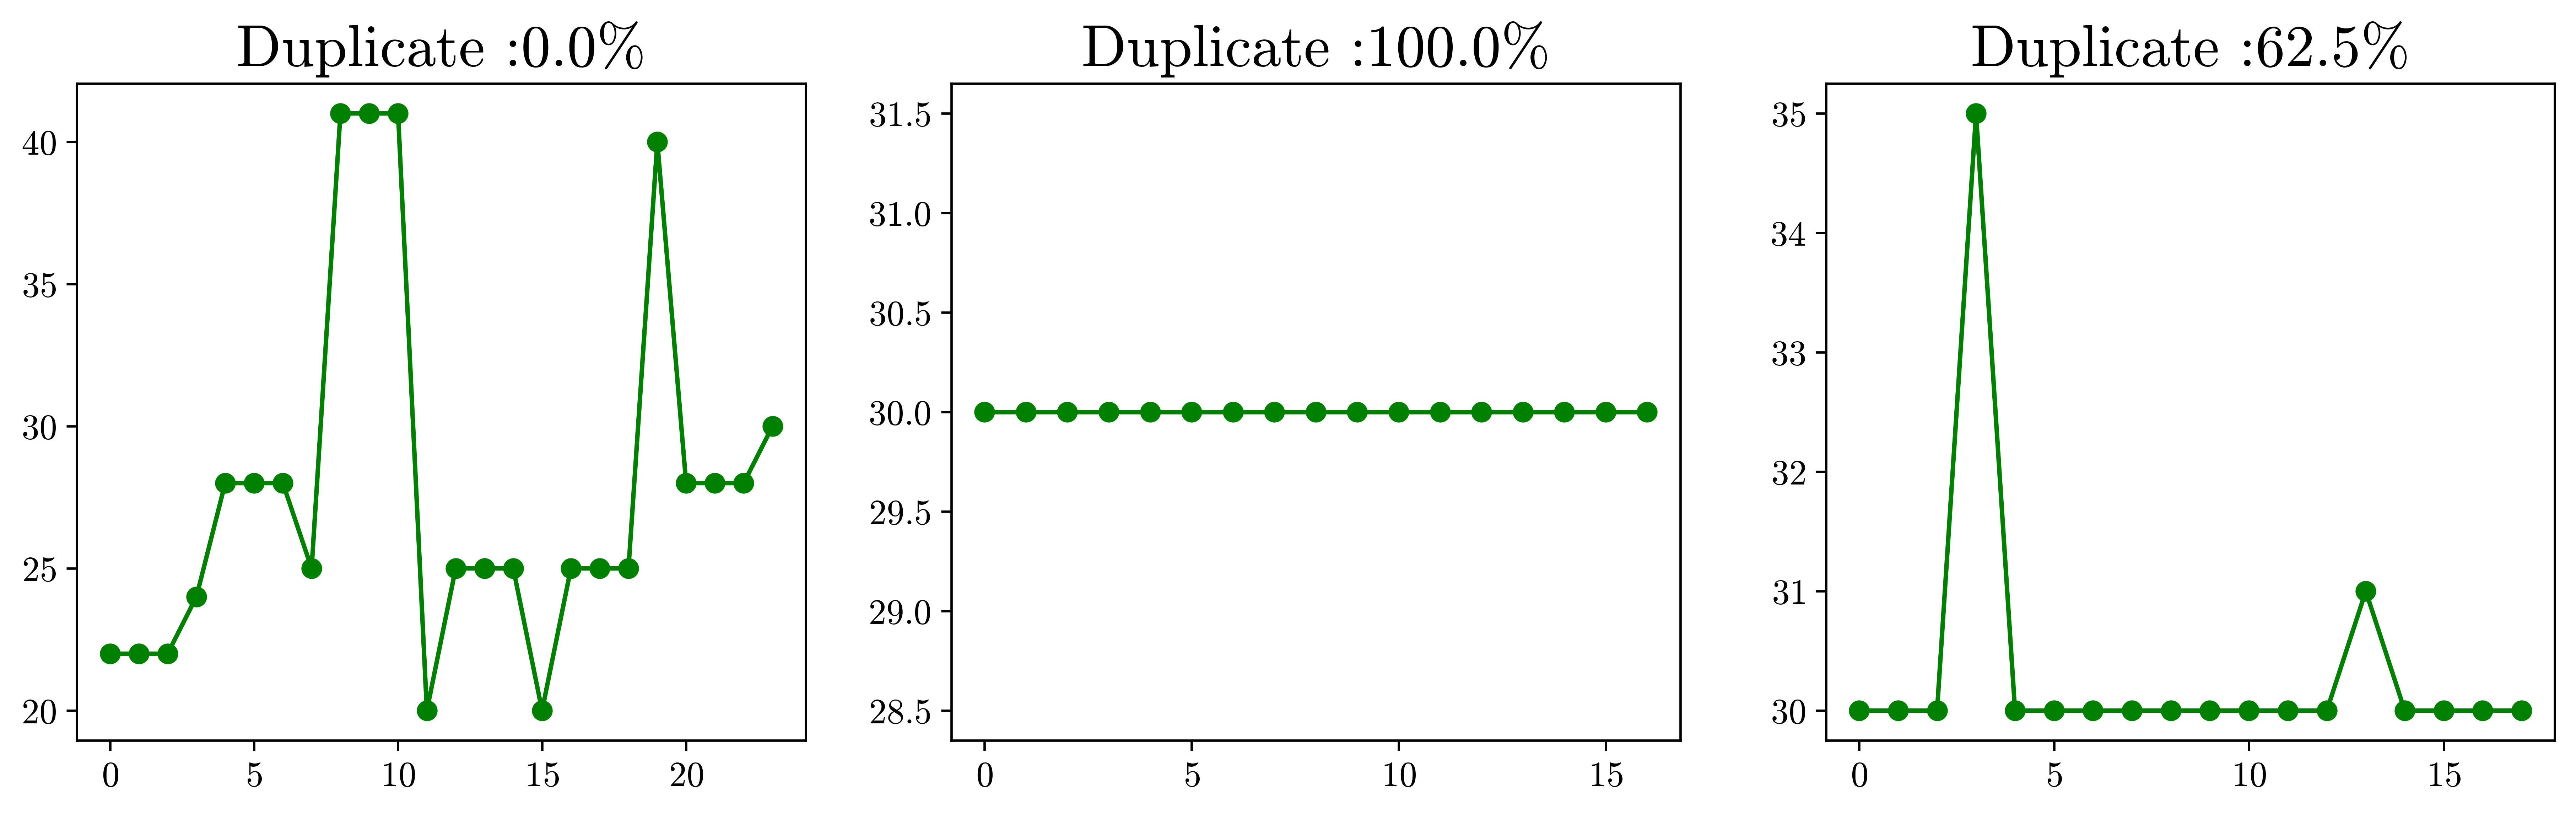

In [4]:
## How duplicate function works

arr1=[22,22,22,24,28,28,28,25,41,41,41,20,25,25,25,20,25,25,25,40,28,28,28,30]
arr2=[30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30]
arr3=[30,30,30,35,30,30,30,30,30,30,30,30,30,31,30,30,30,30]
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Duplicate :'+str(round(calculate_duplicate_percentage(arr1,4),2))+'%')
plt.plot(arr1,'g-o')
plt.subplot(1,3,2)
plt.title('Duplicate :'+str(round(calculate_duplicate_percentage(arr2,4),2))+'%')
plt.plot(arr2,'g-o')
plt.subplot(1,3,3)
plt.title('Duplicate :'+str(round(calculate_duplicate_percentage(arr3,3),2))+'%')
plt.plot(arr3,'g-o')
plt.show()

In [5]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

def knn_interpolate(data):
    arr=data.copy()
    time=np.arange(1,len(arr)+1,1)
    df=pd.DataFrame({'time':time,'arr':arr})
    knn=KNNImputer(n_neighbors=10)
    imputed=pd.DataFrame(knn.fit_transform(np.array(df)),columns=df.columns)['arr'].values
    return imputed


def spline_interpolation(arr, degree):
    x=arr.copy()
    nan_indices = np.isnan(x)
    non_nan_indices = np.arange(len(x))[~nan_indices]
    non_nan_values = arr[~nan_indices]

    if degree==1:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='slinear', fill_value='extrapolate')
    elif degree==2:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='quadratic', fill_value='extrapolate')
    elif degree==3:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='cubic', fill_value='extrapolate')
    
    interpolated_values = interpolator(np.arange(len(x)))

    return interpolated_values

## 1. **Accuracy**
* Anomalous Value : If value in a field is within acceptable range
* Anomalous Multicolumn Relationships : Whether multicolumn relationships in dataset are accurate
* Anomalous Distribution : Whether distribution with micro segments of a record is accurate


##### Anomalous Value

In [6]:
path_data="D:\\BTP\\Data\\site_data_processed"
csv_files=glob.glob(path_data+'/*.csv')
cols=['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']

In [7]:
# dic_min_max={}
# for file in tqdm(csv_files[100:]):
#     df=pd.read_csv(file)
#     for col in cols:
#         if col not in dic_min_max:
#             dic_min_max[col]=[df[col].min(),df[col].min()]
#         else:
#             a,b=dic_min_max[col]
#             a=min(a,df[col].min())
#             b=max(b,df[col].max())
#             dic_min_max[col]=[a,b]
# df_min_max=pd.DataFrame(dic_min_max).T.reset_index()
# df_min_max.columns=['Parameter','Min_val','Max_val']
# df_min_max.to_xlsx('min_max.xlsx',index=False)
# df_min_max

In [8]:
df_min_max=pd.read_excel('min_max.xlsx')
df_min_max

,Parameter,Min_val,Max_val
0,PM2.5,0.01,1000.00
1,PM10,0.01,1000.00
2,SO2,0.01,200.00
3,NO2,0.01,500.00
4,Ozone,0.01,200.00
5,NH3,0.01,499.99


In [9]:
def create_ts_data_multivariate(df,window=25,shift=24):
    arr=[]
    for i in range(0,len(df)-window+1,24):
        temp=df[i:i+window][cols].to_numpy()
        arr.append(temp)
    return np.array(arr)



def anomaly_detection_autoencoders(data_frame):
    data_ts=create_ts_data_multivariate(data_frame)
    model = keras.Sequential() 
    model.add(keras.layers.LSTM(units=32,input_shape=(data_ts.shape[1], data_ts.shape[2])))
    model.add(keras.layers.Dropout(rate=0.1)) 
    model.add(keras.layers.RepeatVector(n=data_ts.shape[1])) 
    model.add(keras.layers.LSTM(units=32, return_sequences=True)) 
    model.add(keras.layers.Dropout(rate=0.1))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=data_ts.shape[2])))
    
    
    model.compile(loss='mae', optimizer='adam')

    history = model.fit( data_ts, data_ts, epochs=250, batch_size=512, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True,verbose=0)], 
                    shuffle=False,
                    verbose=0)
    
    
    data_ts_pred = model.predict(data_ts,verbose=0)
    
    train_mae=np.mean(np.abs(data_ts_pred - data_ts),axis=1)
    threshold=np.median(train_mae,axis=0)+3*np.std(train_mae,axis=0)



    anomalies_arr=[]
    anom_perc=[]
    k=-1

    for col in range(len(cols_pollutant)):
        if cols_pollutant[col] in cols:
            k+=1
            temp=[]
            temp_perc=0
            for i in range(len(train_mae)):
                if train_mae[i][k]>threshold[k]:
                    for _ in range(24):
                        temp.append(1)
                    temp_perc+=24
                else:
                    for _ in range(24):
                        temp.append(0)
                

            if (len(data_frame)-len(temp))>24*2:
                print('Appending too many zeros')

            for _ in range(len(data_frame)-len(temp)):
                temp.append(0)

            anomalies_arr.append(temp)
            anom_perc.append(temp_perc/len(data_frame))
        else:
            anom_perc.append(0)



    anomalies_df=pd.DataFrame(np.array(anomalies_arr).T)
    anomalies_df.columns=['is_anomalies_'+s for s in cols]

    
    return anom_perc

In [12]:
path_data="D:\\BTP\\Data\\site_data_processed"
csv_files=glob.glob(path_data+'/*.csv')

cols_pollutant=['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3']


# df_anomaly=pd.DataFrame({'site_id':[],'PM2.5_anom_perc':[],'PM10_anom_perc':[],'SO2_anom_perc':[],'NO2_anom_perc':[],'Ozone_anom_perc':[],
#                          'NH3_anom_perc':[]})

# for file in tqdm(csv_files):
#     anom_row=[]
#     cols=cols_pollutant.copy()
#     df = pd.read_csv(file)
#     anom_row.append(df['siteId'].unique()[0])
#     df=df[['from date','PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3']]
#     df['from date']=pd.to_datetime(df['from date'])
#     df = df.resample('h', on='from date').mean().reset_index()

#     for pollutant in cols:
#         try:
#             df[pollutant]=linear_int(df[pollutant])
#         except:
#             cols.remove(pollutant)

#     anom_row=anom_row+anomaly_detection_autoencoders(df)

#     df_anomaly.loc[len(df_anomaly)]=anom_row

#df_anomaly.to_excel('Autoencoder_anomalies.xlsx',index=False)
df_anomaly=pd.read_excel('Autoencoder_anomalies.xlsx')
df_anomaly

,site_id,PM2.5_anom_perc,PM10_anom_perc,SO2_anom_perc,NO2_anom_perc,Ozone_anom_perc,NH3_anom_perc
0,site_103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,site_104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,site_105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,site_106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,site_107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
508,site_5848,0.001096,0.001096,0.004932,0.005479,0.000000,0.004932
509,site_5849,0.004384,0.000548,0.006027,0.006027,0.000000,0.006027
510,site_5850,0.003836,0.000548,0.003836,0.003836,0.000000,0.003836
511,site_5851,0.003836,0.002192,0.003836,0.003836,0.002192,0.003836


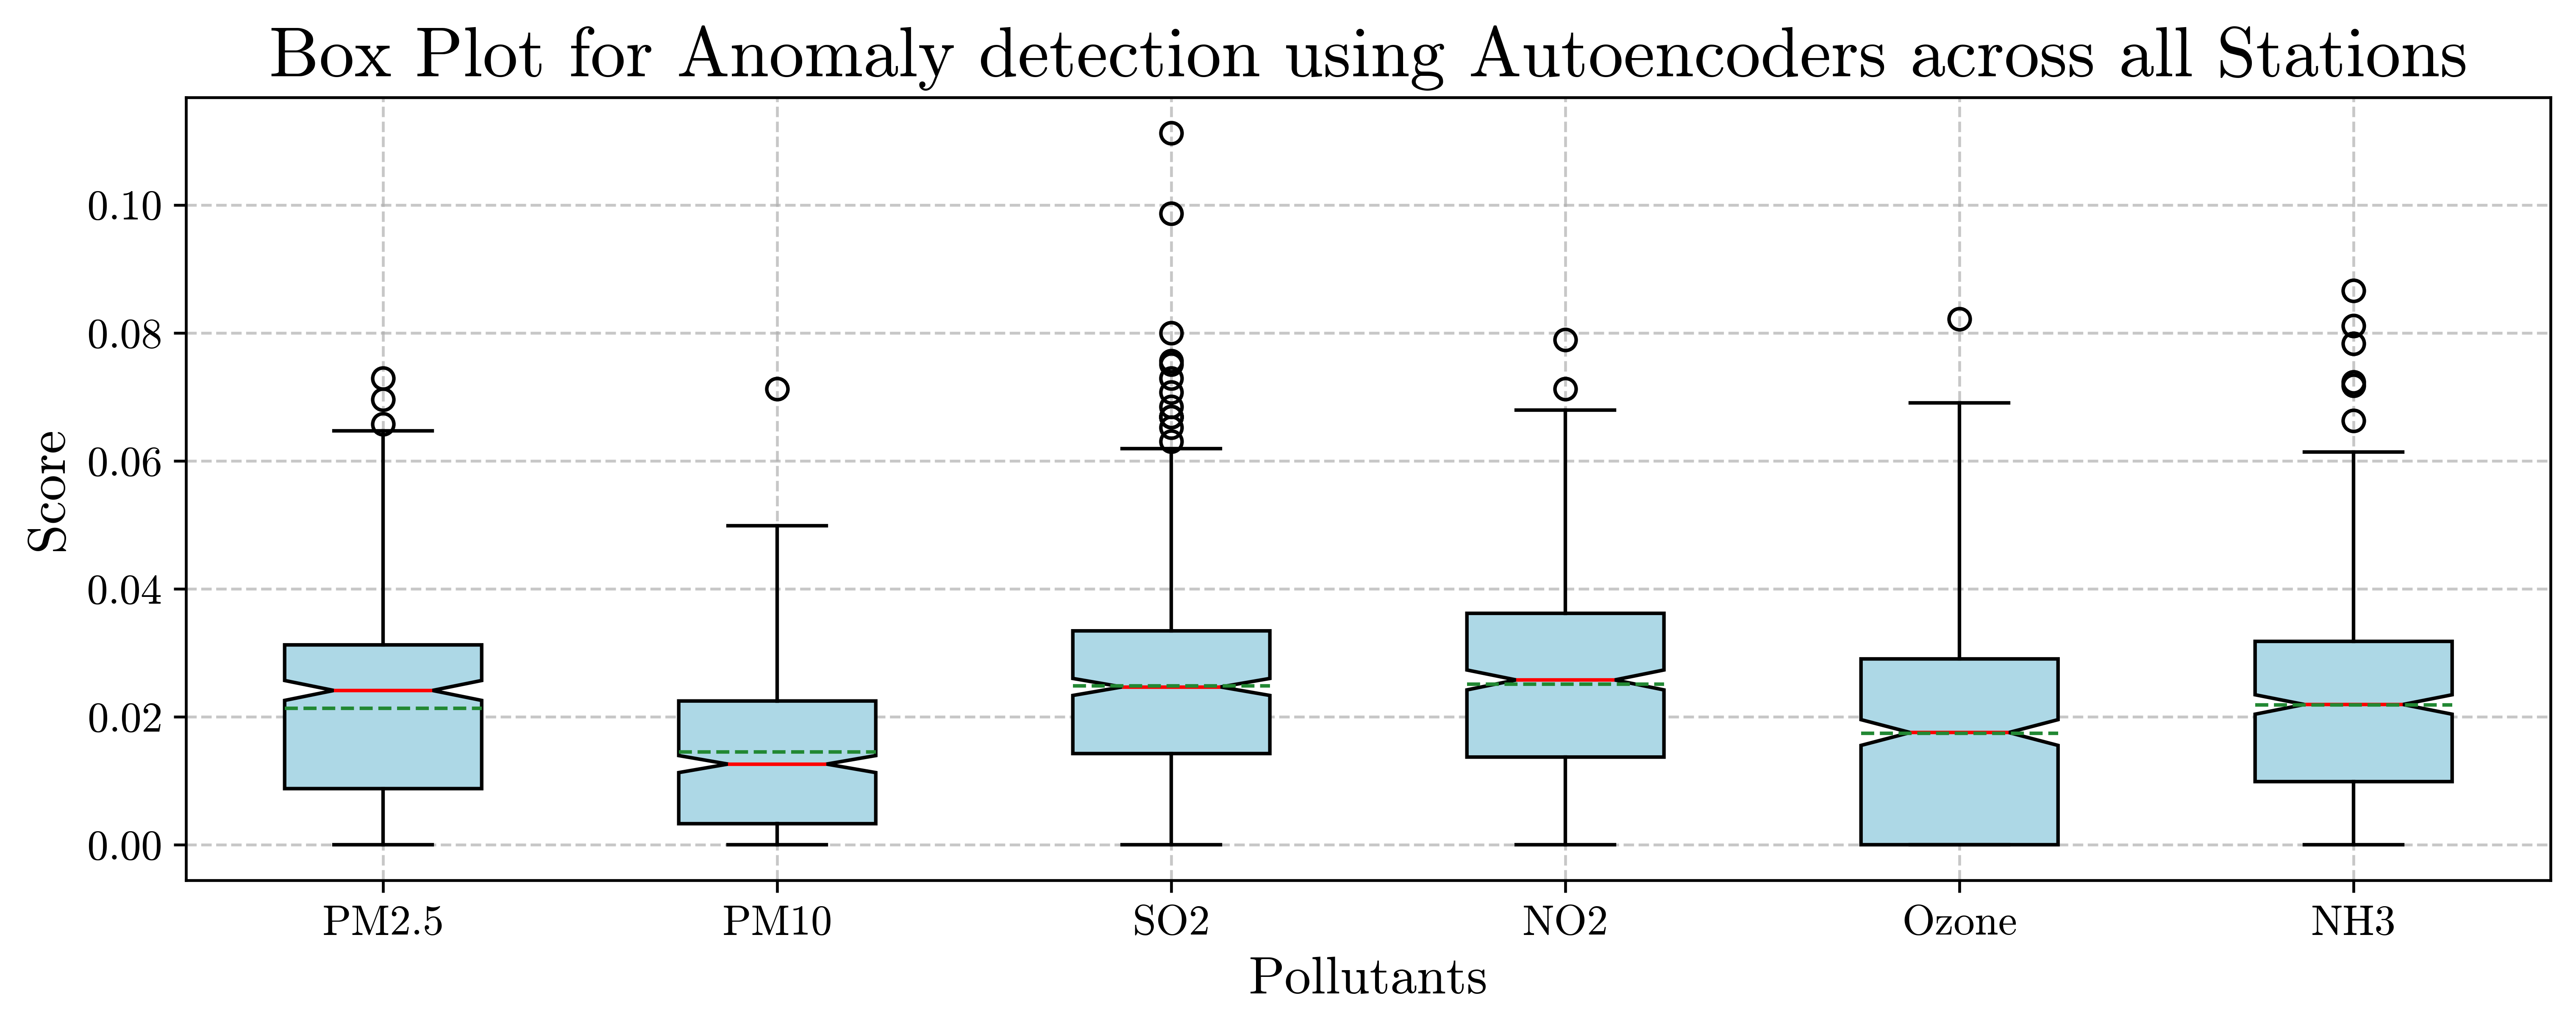

In [15]:
df_anomaly.plot(kind='box', 
                                                                                              figsize=(12, 4), 
                                                                                              vert=True, 
                                                                                              patch_artist=True,  # Fill box with colors
                                                                                              notch=True,  # Add notches
                                                                                              meanline=True,  # Show mean line
                                                                                              showmeans=True,  # Show mean
                                                                                              boxprops=dict(facecolor='lightblue', color='black'),  # Box color
                                                                                              medianprops=dict(color='red'),  # Median line color
                                                                                              whiskerprops=dict(color='black'),  # Whisker color
                                                                                              capprops=dict(color='black'))  # Cap color

# Set title and labels
plt.title('Box Plot for Anomaly detection using Autoencoders across all Stations')
plt.xlabel('Pollutants')
plt.ylabel('Score')

# Customize x-axis ticks
plt.xticks(ticks=range(1, 7), labels=['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### MAD Anomaly Detection

In [67]:
from scipy.stats import median_abs_deviation

def moving_window_mad(data,window,threshold,min_mad,return_zscore=False,return_all=True):
    if window%2==1: # Odd
        start_index=window//2
        end_index=len(data)-start_index
        window_upper=start_index+1
        window_lower=start_index

    else: # Even
        start_index=window//2-1
        end_index=len(data)-(start_index+1)
        window_upper=start_index+2
        window_lower=start_index
    
    t=start_index

    is_anomaly=[-1 for _ in range(start_index)]
    zscore_arr=[0 for _ in range(start_index)]
    mad_arr=[0 for _ in range(start_index)]
    med_arr=[0 for _ in range(start_index)]
    #kurtosis_arr=[0 for _ in range(start_index)]

    #pbar = tqdm(total=end_index-start_index)
    while t<end_index:
        sliding_window=data[t-window_lower:t+window_upper]
        
        med=np.median(sliding_window)
        mad=median_abs_deviation(sliding_window)

        if mad>min_mad:
            mad=1.4826*mad
        else:
            mad=min_mad

        med_arr.append(med)
        mad_arr.append(mad)
        #kurtosis_arr.append(scipy.stats.kurtosis(sliding_window))

        
        zscore=np.abs(data[t]-med)/mad
        zscore_arr.append(zscore)
        if zscore>threshold:
            is_anomaly.append(1)
        else:
            is_anomaly.append(-1)
            
        t+=1
        #pbar.update(1)

    for _ in range(len(data)-end_index):
        is_anomaly.append(-1)
        zscore_arr.append(0)
        mad_arr.append(0)
        med_arr.append(0)
        #kurtosis_arr.append(0)
        
    if return_all:
        return is_anomaly,zscore_arr,mad_arr,med_arr#,kurtosis_arr

    if return_zscore:
        return is_anomaly,zscore_arr

    return is_anomaly

In [35]:
df_min_max['Range']=df_min_max['Max_val']-df_min_max['Min_val']
df_min_max['Range_0.01']=df_min_max['Range']*0.01
df_min_max

,Parameter,Min_val,Max_val,Range,Range_0.01
0,PM2.5,0.01,1000.00,999.99,9.9999
1,PM10,0.01,1000.00,999.99,9.9999
2,SO2,0.01,200.00,199.99,1.9999
3,NO2,0.01,500.00,499.99,4.9999
4,Ozone,0.01,200.00,199.99,1.9999
5,NH3,0.01,499.99,499.98,4.9998


In [39]:
min_mad_dic={'PM2.5':9.99,'PM10':9.99,'SO2':1.99,'NO2':4.99,'Ozone':1.99,'NH3':4.99}

In [89]:
df_site=pd.read_excel('D:\BTP\Data\site_info.xlsx')

True

In [110]:
# #df_anomaly=pd.DataFrame({'site_id':[],'station_name':[],'PM2.5_anom_perc':[],'PM10_anom_perc':[],'SO2_anom_perc':[],'NO2_anom_perc':[],'Ozone_anom_perc':[],
# #                         'NH3_anom_perc':[]})

# for file in tqdm(csv_files[503:]):
#     anom_row=[]
#     cols=cols_pollutant.copy()
#     df = pd.read_csv(file)
#     anom_row.append(df['siteId'].unique()[0])
#     anom_row.append(df['siteName'].unique()[0])
#     df=df[['from date','PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3']]
#     df['from date']=pd.to_datetime(df['from date'])
#     df = df.resample('h', on='from date').mean().reset_index()

#     for pollutant in cols:
#         try:
#             df[pollutant]=linear_int(df[pollutant])
#         except:
#             cols.remove(pollutant)

#     for poll in cols_pollutant:
#         if poll in cols:
#             temp=pd.DataFrame(moving_window_mad(df[poll].values,window=9,threshold=3,min_mad=min_mad_dic[poll],return_all=False))
#             if temp.nunique()[0]==2:
#                 anom_row.append(temp.value_counts()[1]/len(temp))
#             else:
#                 anom_row.append(0)
#         else:
#             anom_row.append(0)

#     df_anomaly.loc[len(df_anomaly)]=anom_row
# df_anomaly.to_excel('MAD_anomalies.xlsx',index=False)
df_anom_MAD=pd.read_excel('MAD_anomalies.xlsx')
df_anom_MAD


,site_id,station_name,PM2.5_anom_perc,PM10_anom_perc,SO2_anom_perc,NO2_anom_perc,Ozone_anom_perc,NH3_anom_perc
0,site_103,"CRRI Mathura Road, Delhi - IMD",0.011164,0.015799,0.000000,0.003470,0.015959,0.000000
1,site_104,"Burari Crossing, Delhi - IMD",0.010023,0.013402,0.000000,0.002192,0.013721,0.000000
2,site_105,"North Campus, DU, Delhi - IMD",0.011164,0.016689,0.000000,0.005228,0.019886,0.000000
3,site_106,"IGI Airport (T3), Delhi - IMD",0.009498,0.017374,0.000000,0.003699,0.006484,0.000000
4,site_107,"Pusa, Delhi - IMD",0.010023,0.014087,0.000000,0.009909,0.009087,0.000000
...,...,...,...,...,...,...,...,...
508,site_5848,"HB Colony, Vijayawada - APPCB",0.000023,0.000046,0.000000,0.000023,0.000091,0.000000
509,site_5849,"Rajiv Gandhi Park, Vijayawada - APPCB",0.000068,0.000068,0.000000,0.000091,0.000137,0.000068
510,site_5850,"Bhoiwada, Dungarpur - RSPCB",0.000000,0.000000,0.000000,0.000000,0.000046,0.000000
511,site_5851,"Mudtra Sili, Jalore - RSPCB",0.000000,0.000068,0.000023,0.000046,0.000091,0.000000


### 2. **Completeness:**
* % of NaN's
* Contiguous missing block length

In [38]:
# def score_data(path):
#     # Calculates Fill Ratio
#     df_out=pd.DataFrame()
#     site_ids=[]
#     station_name=[]
#     for file in tqdm(glob.glob(path+'/*.csv')):
#         df=pd.read_csv(file)
#         site_ids.append(df['siteId'].unique()[0])
#         station_name.append(df['siteName'].unique()[0])
#         df=df[['from date','PM2.5','PM10','SO2',"NO2",'CO','Ozone','NH3']]
#         df_out = pd.concat([df_out, pd.DataFrame((len(df)-df.isna().sum())/len(df)).T], ignore_index=True)
#     df_out.insert(0,'siteId',site_ids)
#     df_out.insert(0,'siteName',station_name)
#     return df_out


# path_data="D:\\BTP\\Data\\site_data_processed" # Path to folder containing all csv's
# df_fill_ratio=score_data(path_data)
# temp=df_fill_ratio[['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']].mean(axis=1)
# df_fill_ratio['mean_fill_ratio']=temp
# df_fill_ratio.to_excel('fill_ratio.xlsx',index=False)

In [71]:
df_score=pd.read_excel('Score_all_files.xlsx')
df_score.sort_values(['PM2.5_score','PM10_score','SO2_score','NO2_score','Ozone_score','NH3_score'],ascending=False)

,SiteId,SiteName,PM2.5_score,PM10_score,SO2_score,NO2_score,Ozone_score,NH3_score,PM2.5_dup_score,PM10_dup_score,SO2_dup_score,NO2_dup_score,Ozone_dup_score,NH3_dup_score
46,site_1425,"Major Dhyan Chand National Stadium, Delhi - DPCC",0.9684,0.9617,0.9102,0.9457,0.9257,0.9178,50.988316,49.258834,1.743181,0.059933,0.506858,0.223748
49,site_1428,"Okhla Phase-2, Delhi - DPCC",0.9684,0.9595,0.9057,0.9416,0.8962,0.8902,50.777125,49.007118,0.533114,0.046804,0.100458,0.223748
50,site_1429,"Nehru Nagar, Delhi - DPCC",0.9670,0.9610,0.9019,0.8643,0.9054,0.9467,50.376433,49.248560,0.364732,0.029681,0.110162,0.094180
79,site_1562,"Sri Aurobindo Marg, Delhi - DPCC",0.9648,0.9610,0.8819,0.9468,0.9188,0.9301,50.862743,49.640119,0.457200,0.101029,0.180939,0.696930
43,site_1422,"Dwarka-Sector 8, Delhi - DPCC",0.9627,0.9505,0.8601,0.9398,0.9263,0.9210,49.923800,48.346147,1.694664,0.019407,0.469757,0.070777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,site_5848,"HB Colony, Vijayawada - APPCB",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.139843,0.138130,0.000000,0.000000,0.000000,0.000000
509,site_5849,"Rajiv Gandhi Park, Vijayawada - APPCB",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.164386,0.163816,0.000000,0.000000,0.000000,0.000000
510,site_5850,"Bhoiwada, Dungarpur - RSPCB",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.180368,0.180939,0.011416,0.002283,0.000000,0.053083
511,site_5851,"Mudtra Sili, Jalore - RSPCB",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.143838,0.115299,0.018265,0.000000,0.000000,0.002854


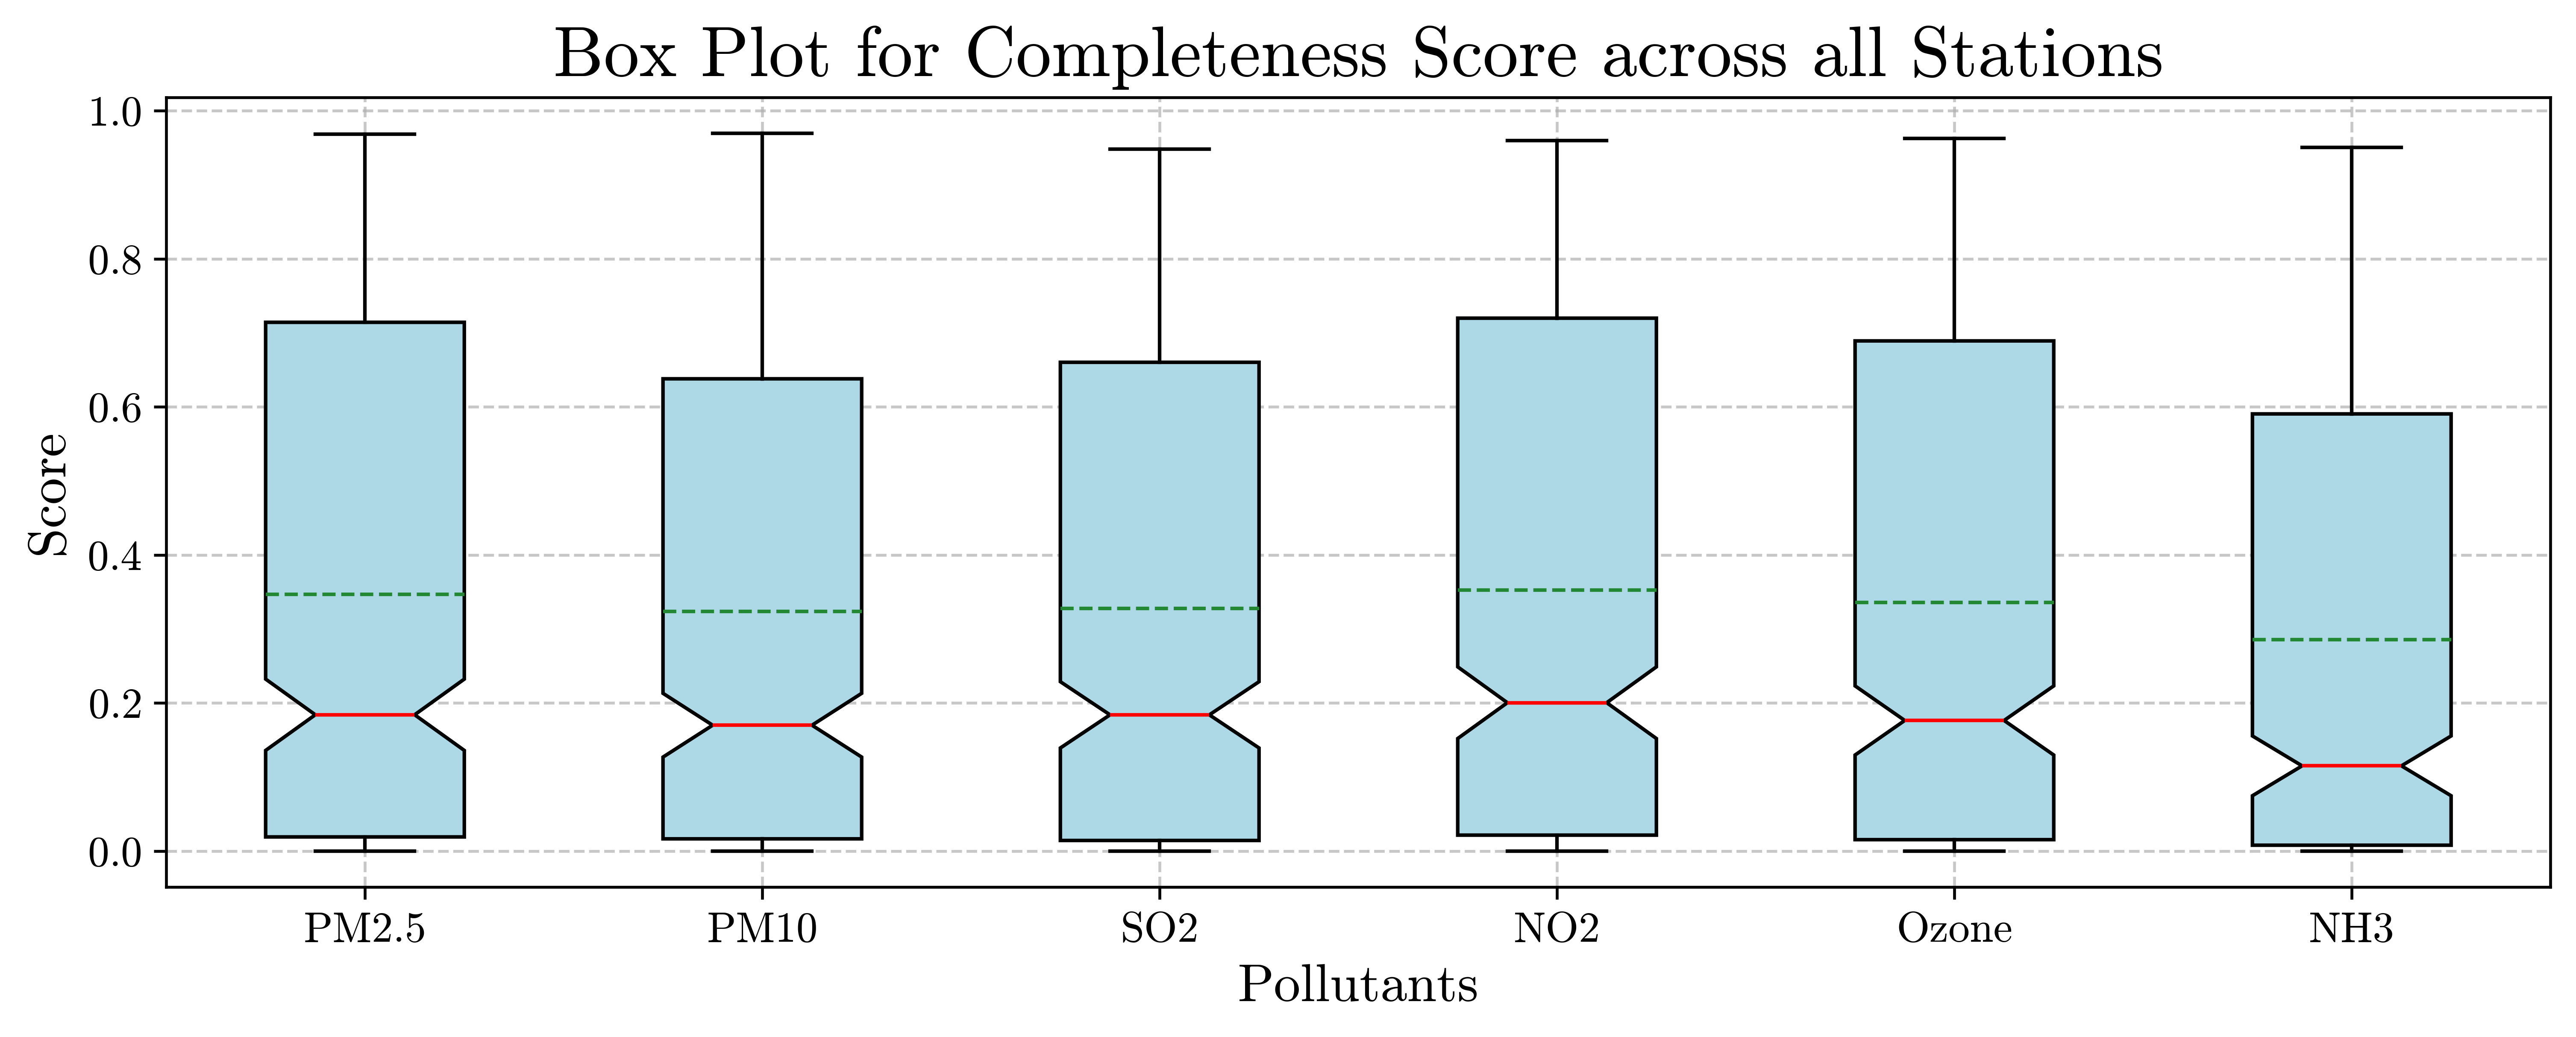

In [72]:
# Plot the box plot with customizations
df_score[['PM2.5_score','PM10_score','SO2_score','NO2_score','Ozone_score','NH3_score']].plot(kind='box', 
                                                                                              figsize=(12, 4), 
                                                                                              vert=True, 
                                                                                              patch_artist=True,  # Fill box with colors
                                                                                              notch=True,  # Add notches
                                                                                              meanline=True,  # Show mean line
                                                                                              showmeans=True,  # Show mean
                                                                                              boxprops=dict(facecolor='lightblue', color='black'),  # Box color
                                                                                              medianprops=dict(color='red'),  # Median line color
                                                                                              whiskerprops=dict(color='black'),  # Whisker color
                                                                                              capprops=dict(color='black'))  # Cap color

# Set title and labels
plt.title('Box Plot for Completeness Score across all Stations')
plt.xlabel('Pollutants')
plt.ylabel('Score')

# Customize x-axis ticks
plt.xticks(ticks=range(1, 7), labels=['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### 3.**Uniqueness:**
This metric tracks duplicate data. Counting any data twice will unduly weigh the results. It is important to either merge duplicate records or delete them. 


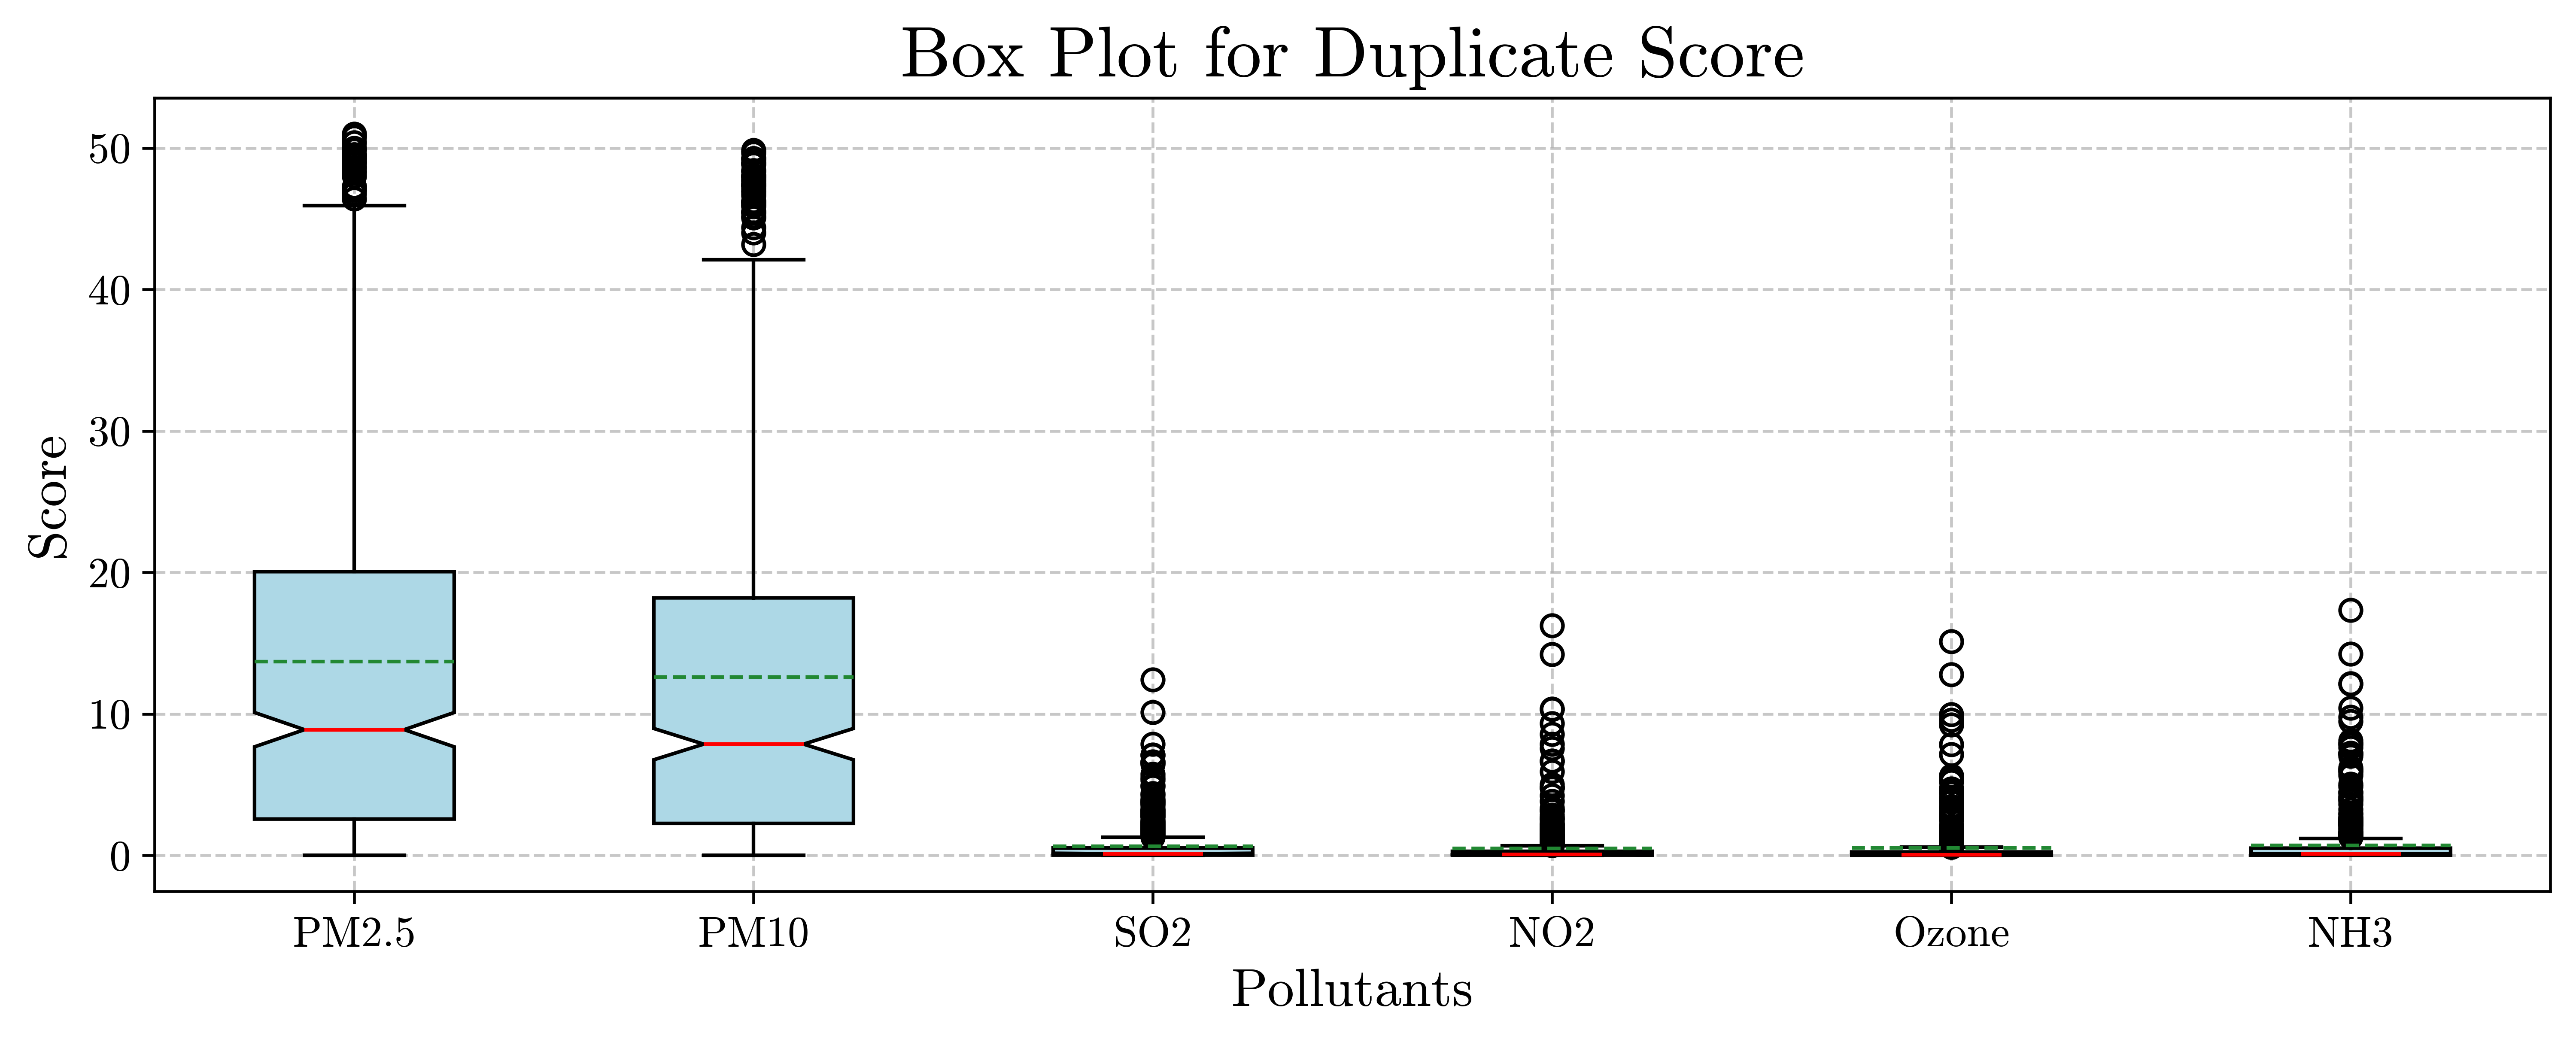

In [10]:
# Plot the box plot with customizations
df_score[['PM2.5_dup_score','PM10_dup_score',
          'SO2_dup_score','NO2_dup_score',
          'Ozone_dup_score','NH3_dup_score']].plot(kind='box',
                                                                                           figsize=(12, 4), 
                                                                                           vert=True, 
                                                                                           patch_artist=True,  # Fill box with colors
                                                                                           notch=True,  # Add notches
                                                                                           meanline=True,  # Show mean line
                                                                                           showmeans=True,  # Show mean
                                                                                           boxprops=dict(facecolor='lightblue', color='black'),  # Box color
                                                                                           medianprops=dict(color='red'),  # Median line color
                                                                                           whiskerprops=dict(color='black'),  # Whisker color
                                                                                           capprops=dict(color='black'))  # Cap color

# Set title and labels
plt.title('Box Plot for Duplicate Score')
plt.xlabel('Pollutants')
plt.ylabel('Score')

# Customize x-axis ticks
plt.xticks(ticks=range(1, 7), labels=['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


### 4. **Consitency:**
Consistency is used to check if data from one or more sources do not conflict with one another.  Checking for consistency determines if your data is in the same data format or structure for effective data integration.

### 5. **Timeliness:**
Timeliness is tracked via timestamp. It is advisable to use recent data for analysis as it will have more accurate and relevant information. Fields related to customer information, pollution profile of cities can change significantly over shorter time intervals.

### 6.**Validity:**
It measures how well data conforms to the standards, i.e. if wrong data format is entered in a field then it becomes unusable. It is important to check if a given field has correct data types. 

In [ ]:
cols=list(df_anom_MAD.columns)
cols[0]='SiteId'
df_anom_MAD.columns=cols

df_score.merge(df_anom_MAD,on='SiteId').to_csv('Stations_Score.csv',index=False)